In [1]:
from preprocessing import ProcessData

Loaded preprocessed data from /Users/bragehs/Documents/INF367A-DeforestationDrivers
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


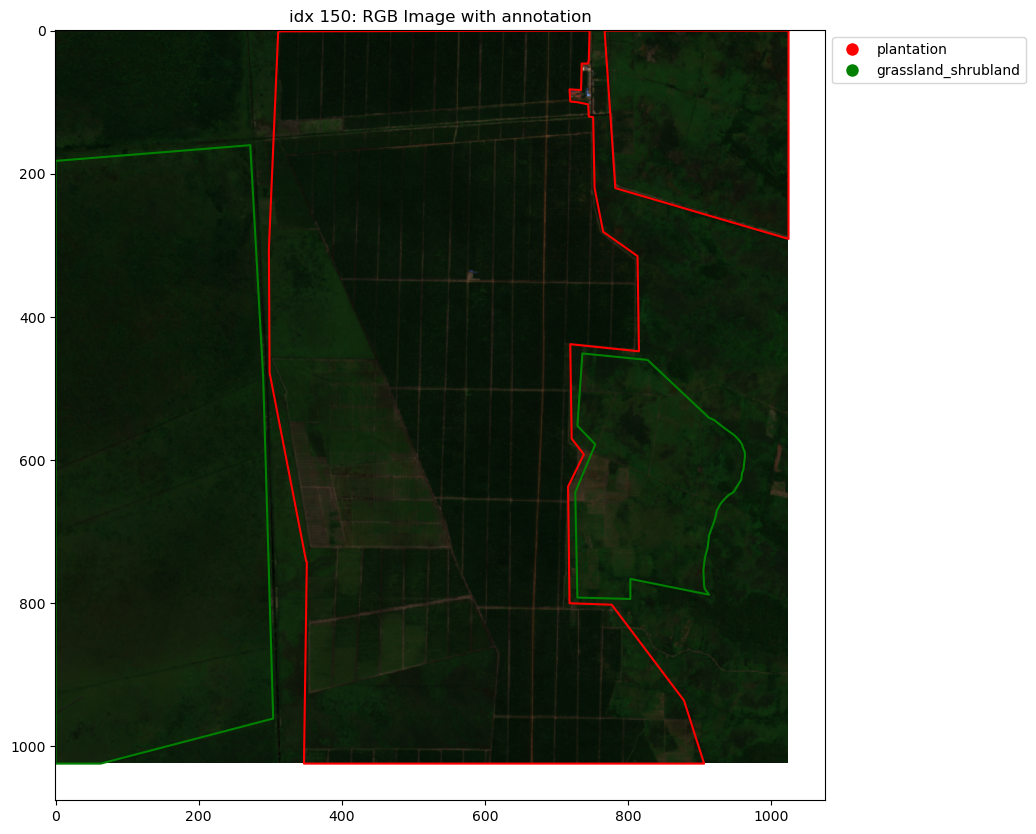

In [7]:
data = ProcessData()
data.visualize_in_RGB(start=150, n=151)

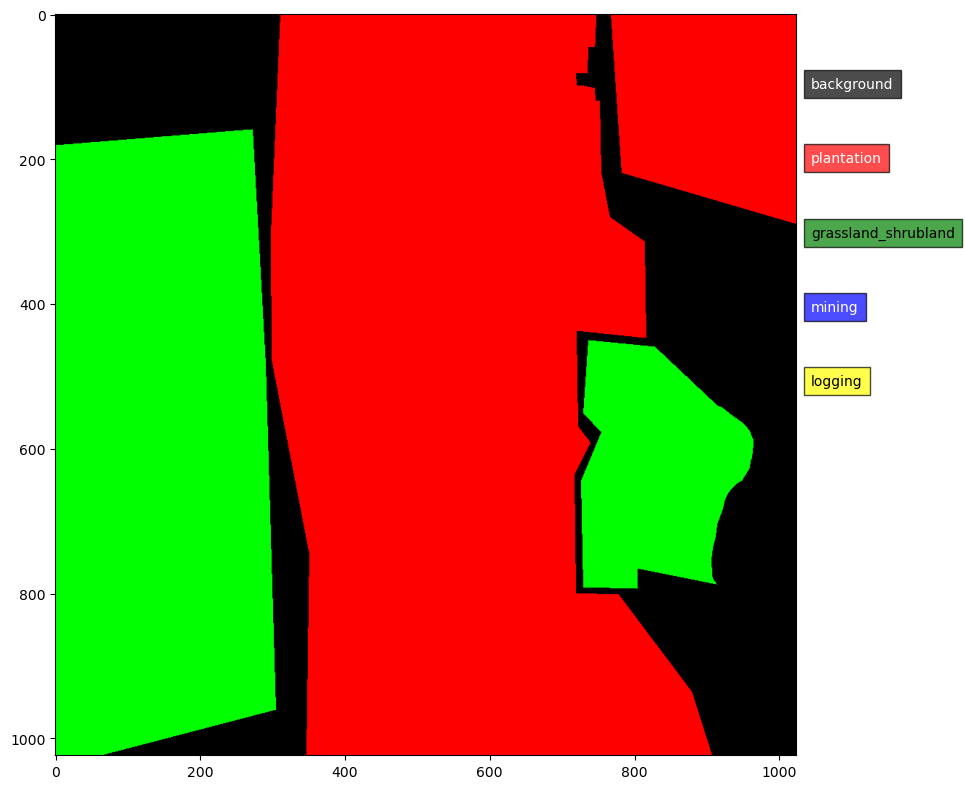

In [8]:
data.visualize_rasterized(start=150, n=151)

In [4]:
data = ProcessData()
data.preprocess()
data.save_preprocessed()

Processing train_0.tif
Processing train_1.tif
Processing train_2.tif
Processing train_3.tif
Processing train_4.tif
Processing train_5.tif
Processing train_6.tif
Processing train_7.tif
Processing train_8.tif
Processing train_9.tif
Processing train_10.tif
Processing train_11.tif
Processing train_12.tif
Processing train_13.tif
Processing train_14.tif
Processing train_15.tif
Processing train_16.tif
Processing train_17.tif
Processing train_18.tif
Processing train_19.tif
Processing train_20.tif
Processing train_21.tif
Processing train_22.tif
Processing train_23.tif
Processing train_24.tif
Processing train_25.tif
Processing train_26.tif
Processing train_27.tif
Processing train_28.tif
Processing train_29.tif
Processing train_30.tif
Processing train_31.tif
Processing train_32.tif
Processing train_33.tif
Processing train_34.tif
Processing train_35.tif
Processing train_36.tif
Processing train_37.tif
Processing train_38.tif
Processing train_39.tif
Processing train_40.tif
Processing train_41.tif
Pr

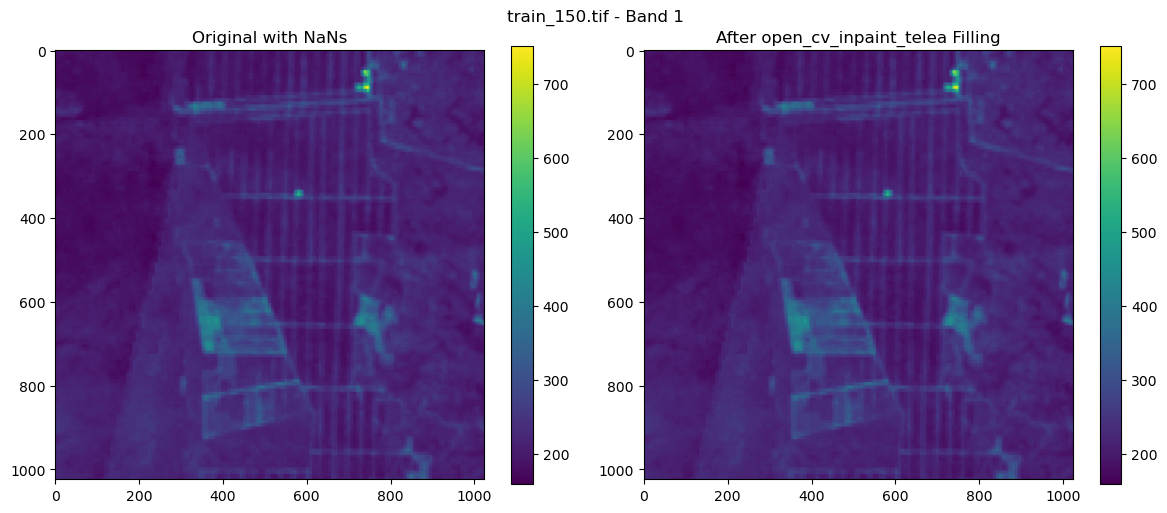

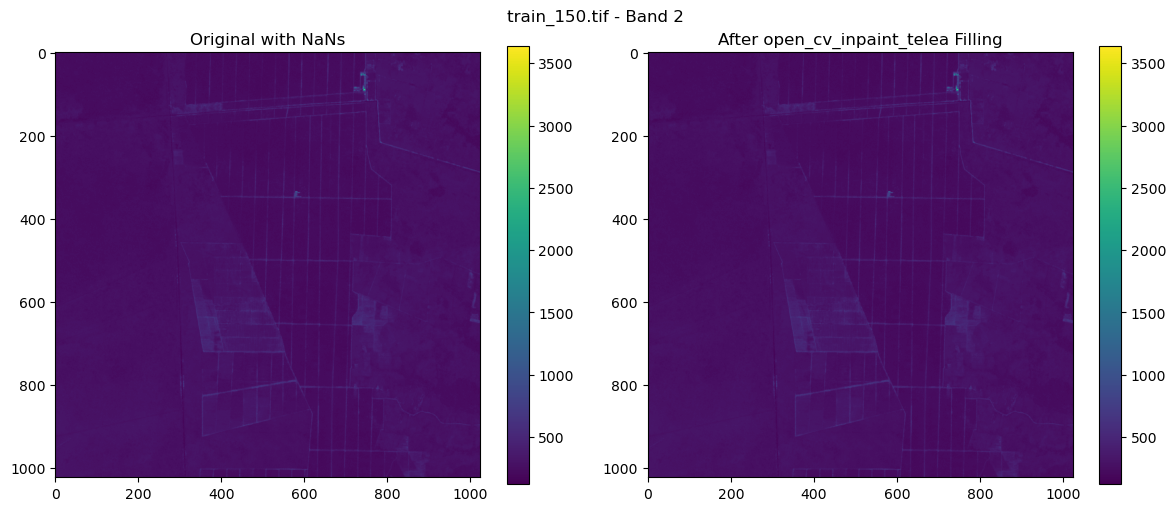

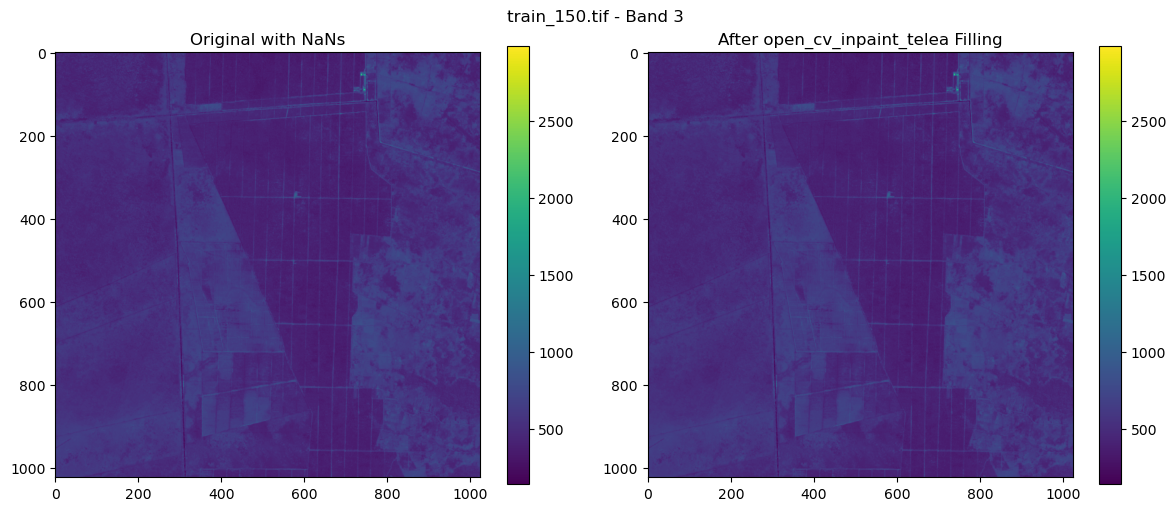

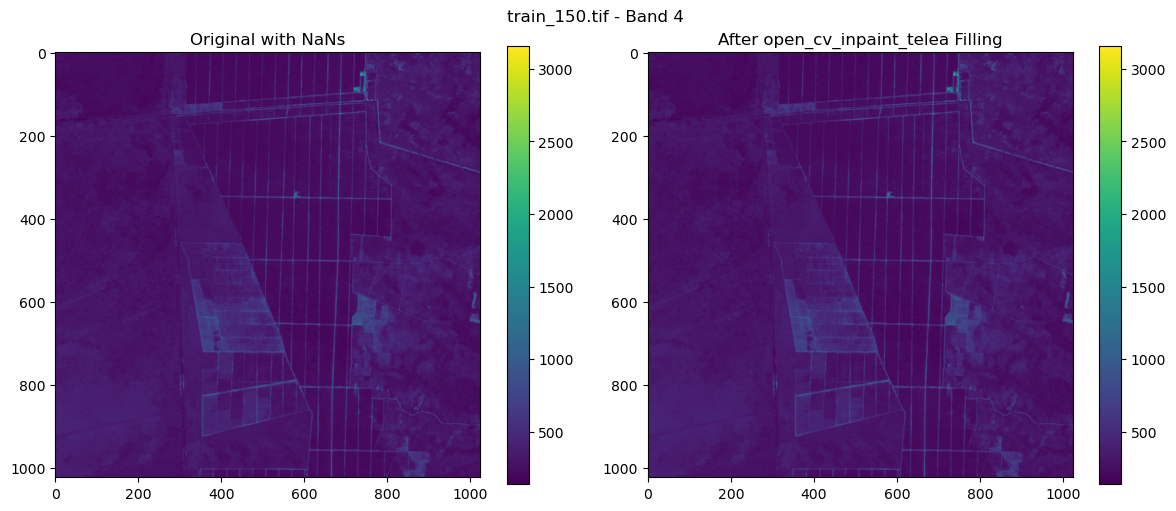

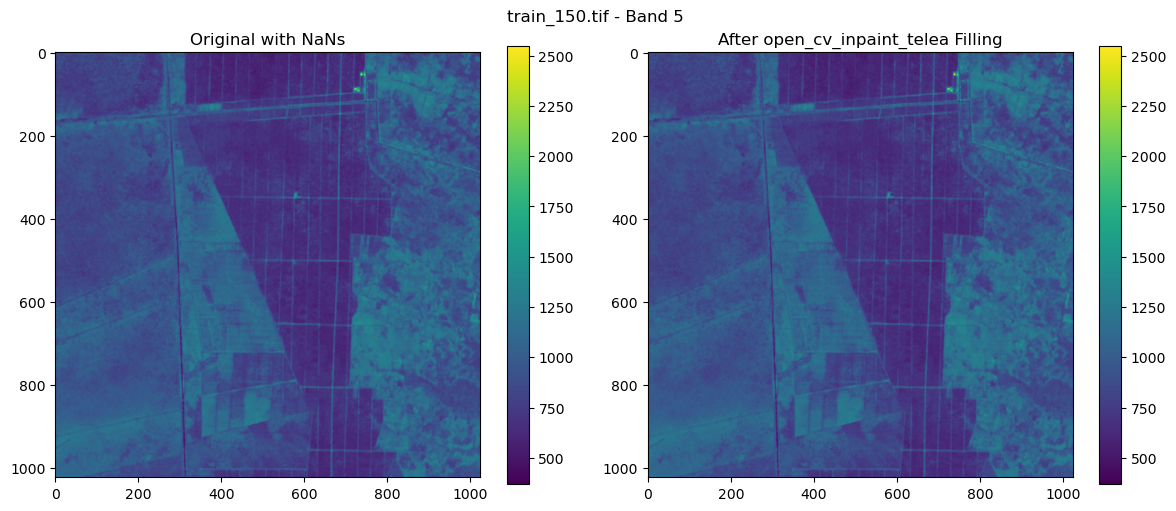

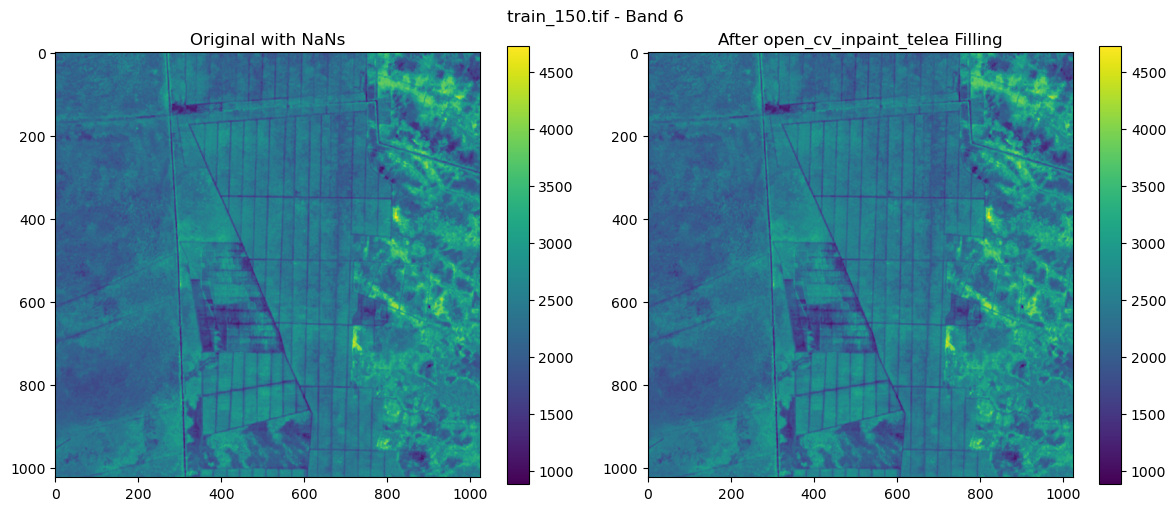

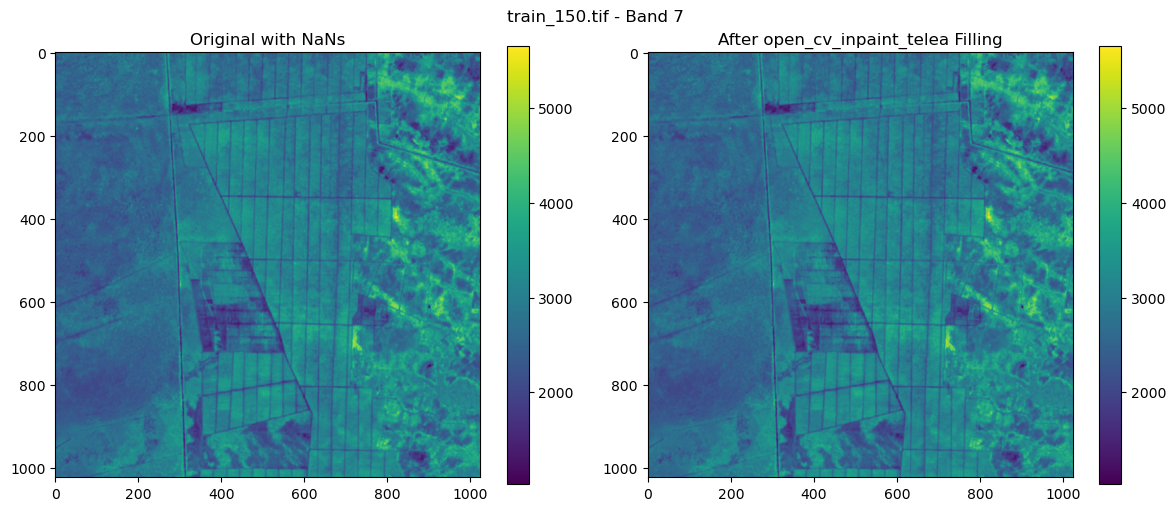

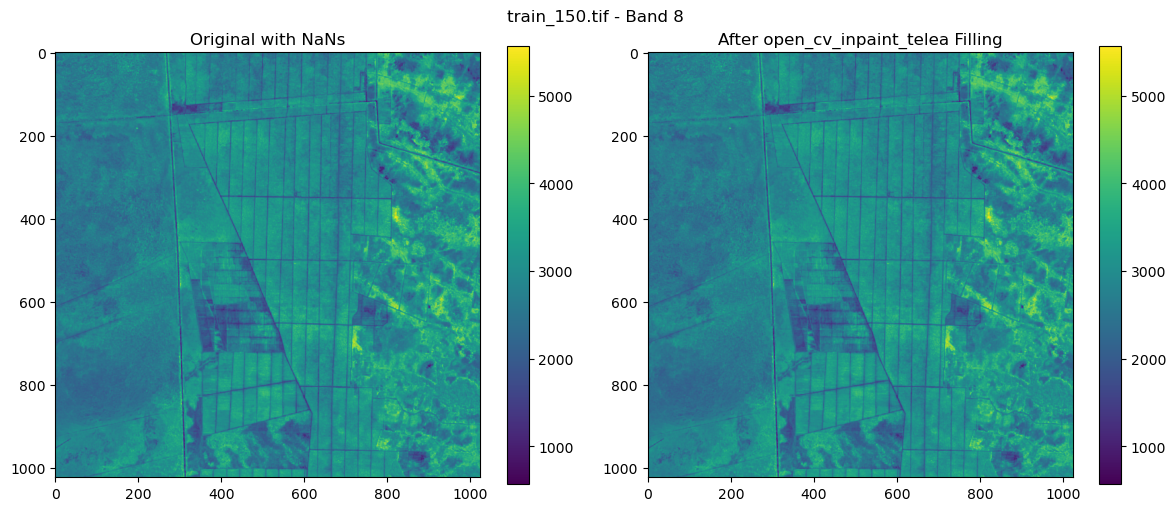

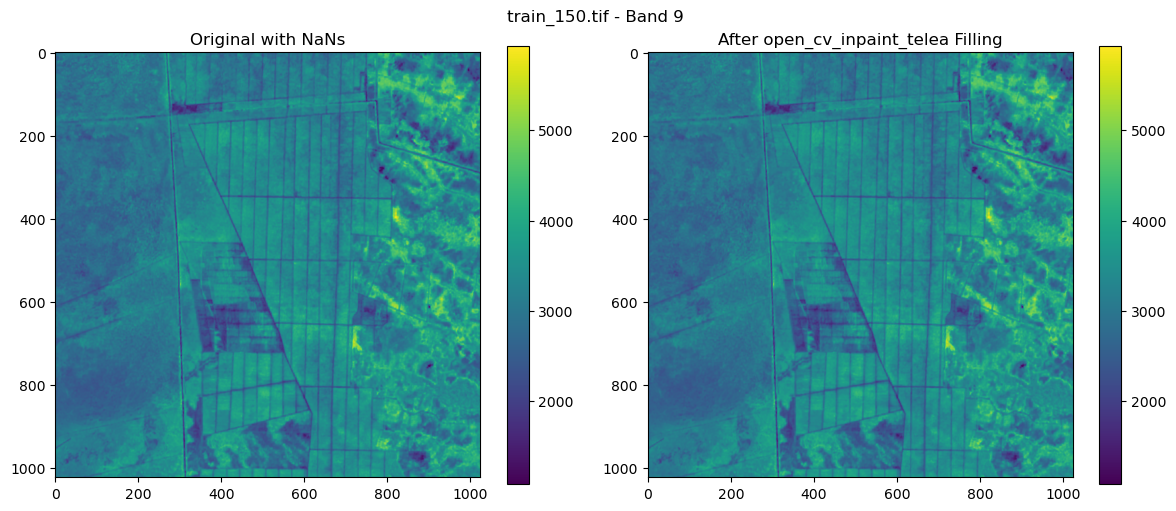

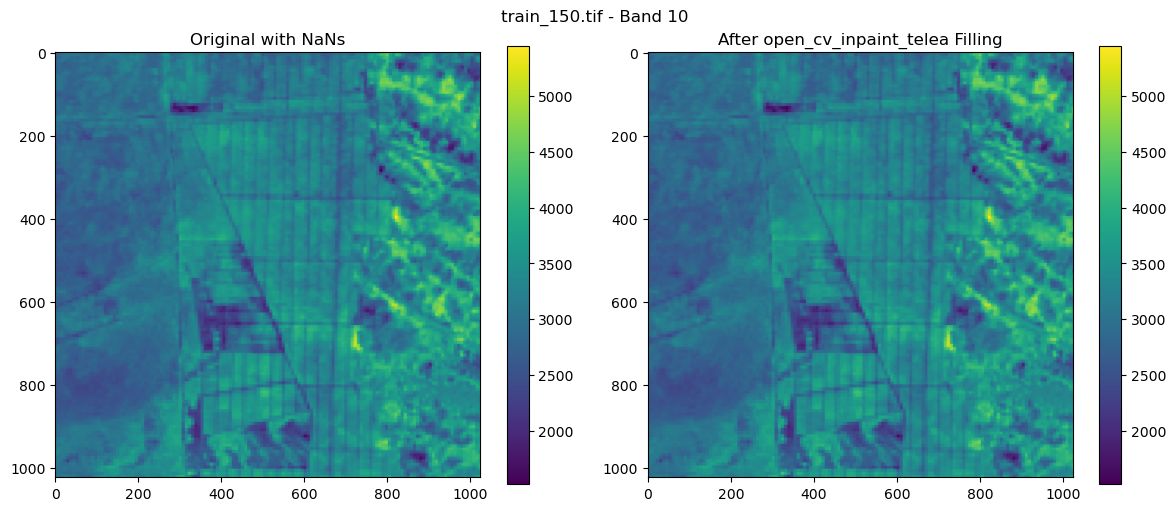

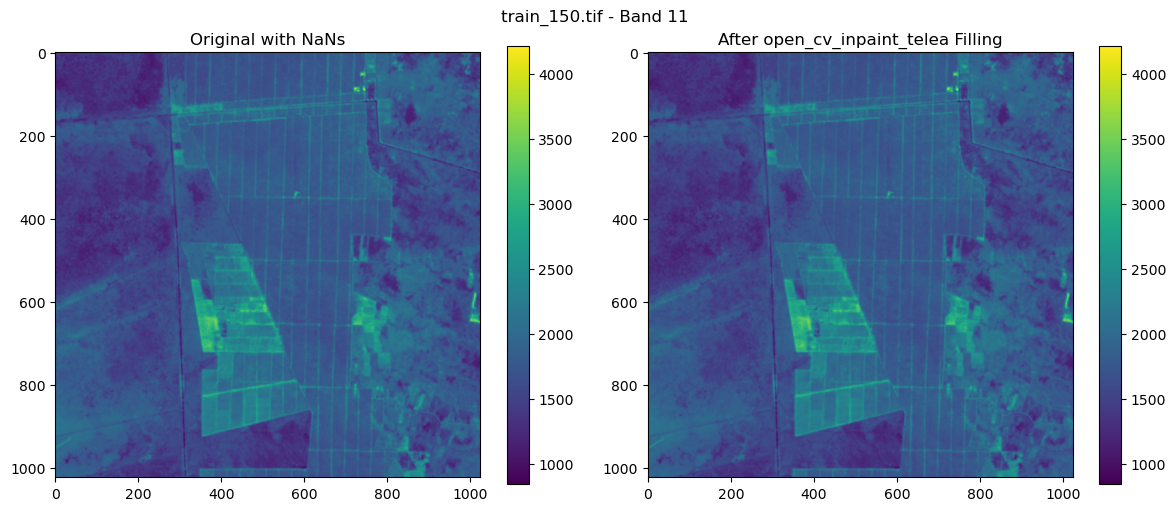

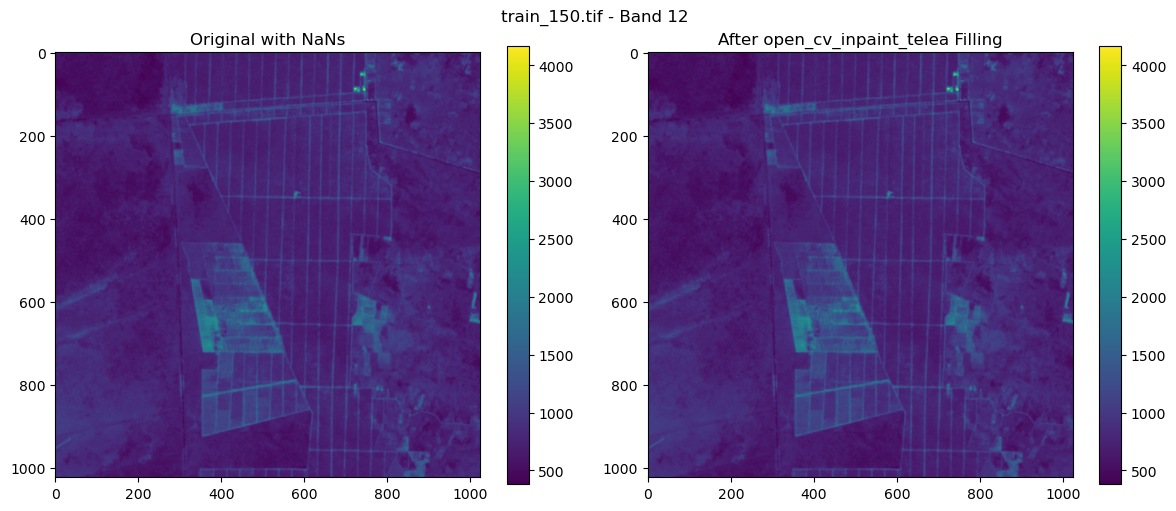

In [6]:
data.visualize_nan_filling(start=150, n=151)

In [3]:
from preprocessing import ProcessData

In [4]:
data = ProcessData()
data.prepared_data, data.labels = data.load_preprocessed_data()

Loaded preprocessed data from /Users/bragehs/Documents/INF367A-DeforestationDrivers


In [5]:
prepared_data = data.prepared_data
labels = data.labels 

In [6]:
prepared_data[0][-1]

array([[ 880. , 1025. , 1025. , ...,  516. ,  535.5,  535.5],
       [ 865. , 1074. , 1074. , ...,  563. ,  549.5,  549.5],
       [ 865. , 1074. , 1074. , ...,  563. ,  549.5,  549.5],
       ...,
       [2165. , 2035. , 2035. , ..., 2043. , 2044.5, 2044.5],
       [1914.5, 3081. , 3081. , ..., 2043. , 2044.5, 2044.5],
       [1914.5, 3081. , 3081. , ..., 2043. , 2044.5, 2044.5]])

In [7]:
bands_indices = [1, 2, 3, 4, 5, 6, 7, 10, 11]
prepared_data = prepared_data[:, bands_indices]

In [16]:
x = prepared_data[:1]
x.shape

(1, 9, 1024, 1024)

In [17]:
y = labels[:1]
y.shape

(1, 1024, 1024)

In [11]:
x[0][0]

array([[ 260. ,  228. ,  228. , ...,  201.5,  231. ,  238.5],
       [ 250. ,  239. ,  239. , ...,  224.5,  228.5,  227.5],
       [ 203. ,  249. ,  249. , ...,  227. ,  209. ,  219. ],
       ...,
       [ 982.5,  894. ,  894. , ...,  618.5,  676. ,  655.5],
       [ 699. , 1226. , 1226. , ...,  618.5,  676. ,  655.5],
       [ 559. , 1172. , 1172. , ...,  637.5,  674. ,  627.5]])

In [10]:
import numpy as np

In [24]:
def normalize_sentinel2(tci_rgb, bands):
    # tci_rgb: shape (height, width, 3), 8-bit data in [0..255]
    tci_norm = (tci_rgb - tci_rgb.min()) / (tci_rgb.max() - tci_rgb.min())

    # bands: list of np arrays [B05, B06, B07, B08, B11, B12], each 16-bit
    normalized_bands = []
    for band in bands:
        norm_band = np.clip(band / 8160.0, 0, 1)
        normalized_bands.append(norm_band)

    # Stack into final tensor
    normalized_bands = np.array(normalized_bands)
    print(normalized_bands.shape, tci_norm.shape)
    return np.concatenate([tci_norm, normalized_bands], axis=1)

In [27]:
normalized = normalize_sentinel2(prepared_data[::, :3 :], prepared_data[:1:, 3: :])

KeyboardInterrupt: 

In [29]:
x.shape

(1, 9, 1024, 1024)

In [30]:
import numpy as np
from typing import Tuple, Iterator

def batch_generator(images: np.ndarray, labels: np.ndarray, batch_size: int) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """Generate batches of images and labels."""
    num_samples = len(images)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        yield images[start_idx:end_idx], labels[start_idx:end_idx]

def augment_data(images: np.ndarray, labels: np.ndarray, batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    """
    Memory-efficient data augmentation processing images in batches.
    
    Args:
        images: Input images of shape (N, 9, 1024, 1024)
        labels: Input labels of shape (N, 1024, 1024)
        batch_size: Number of images to process at once
    
    Returns:
        Tuple of augmented images and labels
    """
    transforms = [
        (0, None),     # Original
        (1, None),     # 90° rotation
        (2, None),     # 180° rotation
        (3, None),     # 270° rotation
        #(0, 0),        # Horizontal Flip
        #(0, 1),        # Vertical Flip
        #(1, 0),        # 90° + Horizontal Flip
        #(3, 1)         # 270° + Vertical Flip
    ]
    
    num_aug = len(transforms)
    num_samples = len(images)
    total_samples = num_samples * num_aug
    
    # Initialize empty lists to store augmented data
    aug_images_list = []
    aug_labels_list = []
    
    # Process in batches
    for batch_imgs, batch_lbls in batch_generator(images, labels, batch_size):
        batch_aug_images = []
        batch_aug_labels = []
        
        for img, lbl in zip(batch_imgs, batch_lbls):
            for rot, flip in transforms:
                # Perform augmentations
                img_aug = np.rot90(img, rot, axes=(1, 2))
                lbl_aug = np.rot90(lbl, rot, axes=(0, 1))
                
                if flip is not None:
                    img_aug = np.flip(img_aug, axis=flip + 1)
                    lbl_aug = np.flip(lbl_aug, axis=flip)
                
                batch_aug_images.append(img_aug)
                batch_aug_labels.append(lbl_aug)
        
        # Convert batch lists to arrays and append to main lists
        aug_images_list.append(np.stack(batch_aug_images))
        aug_labels_list.append(np.stack(batch_aug_labels))
    
    # Concatenate all batches
    aug_images = np.concatenate(aug_images_list)
    aug_labels = np.concatenate(aug_labels_list)
    
    return aug_images, aug_labels

In [31]:
augmented_data, augmented_labels = augment_data(prepared_data, labels, batch_size=8)

: 

In [23]:
augmented_data.shape, augmented_labels.shape    

((8, 9, 1024, 1024), (8, 1024, 1024))